### Note! This code utilizes a large dataset (approx 500MB). Please be patient while running code.

In [1]:
# import dependencies

import re
import os
import csv
import pandas as pd
from dotenv import load_dotenv
import nltk
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import numpy as np

%matplotlib inline

### Process 2020 Social Media Post Data

In [2]:
# Define the file path
file_path = "../Source_data/posts_2020.csv"

# Initialize an empty DataFrame to hold the filtered data
posts_2020_df = pd.DataFrame()

# Define the acceptable values for the 'country' column
acceptable_countries = ["United States", "United States of America"]

# Process the file in chunks to handle large files
chunk_size = 10**6  # Adjust the chunk size based on your system's memory capacity
for chunk in pd.read_csv(
    file_path,
    engine='python',                  # Use Python engine to handle more complex cases
    on_bad_lines='skip',              # Skip problematic lines
    delimiter=',',                    # Ensure correct delimiter
    chunksize=chunk_size              # Read the file in chunks
):
    # Filter rows based on the 'country' column
    filtered_chunk = chunk[chunk['country'].isin(acceptable_countries)]
    # Append the filtered chunk to the main DataFrame
    posts_2020_df = pd.concat([posts_2020_df, filtered_chunk], ignore_index=True)

# Verify the result
posts_2020_df.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:02,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.5202471,-122.6741949,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
2,2020-10-15 00:00:08,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.8949924,-77.0365581,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121
3,2020-10-15 00:00:17,1.316529291052675e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,Twitter for Android,1138416104.0,Farris Flagg,FarrisFlagg,#BidenHarris2020 #JoeBiden2020 #KamalaHarrisFo...,...,2363.0,"Perris,California",33.7825194,-117.22864779999999,NaN,United States of America,North America,California,CA,2020-10-21 00:00:01.866082651
4,2020-10-15 00:00:18,1.3165292934979625e+18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,Twitter for iPhone,9.007610716314296e+17,Stacey Gulledge 🇺🇸 Patriot ♥️ KAG 🙏 👮‍♀️♥️,sm_gulledge,"Patriot, Wife, “Shaken not Stirred” Mom of two...",...,766.0,"Ohio, USA",40.225356899999994,-82.6881395,NaN,United States of America,North America,Ohio,OH,2020-10-21 00:00:02.612515712


In [3]:
# Restrict dataframe to columns of interest

# Rename columns
posts_2020_df.rename(columns={
    'user_screen_name': 'handle',
    'tweet': 'text',
    'created_at': 'time',
    'tweet_id': 'id'
}, inplace=True)

# Select only the required columns
posts_2020_df = posts_2020_df[['id', 'handle', 'text', 'time']]

# Verify the result
posts_2020_df.head()

,id,handle,text,time
0,1.316529221557252e+18,elsollatinonews,#Elecciones2020 | En #Florida: #JoeBiden dice ...,2020-10-15 00:00:01
1,1.316529228091847e+18,snarke,"#Trump: As a student I used to hear for years,...",2020-10-15 00:00:02
2,1.3165292523014513e+18,Ranaabtar,You get a tie! And you get a tie! #Trump ‘s ra...,2020-10-15 00:00:08
3,1.316529291052675e+18,FarrisFlagg,@CLady62 Her 15 minutes were over long time ag...,2020-10-15 00:00:17
4,1.3165292934979625e+18,sm_gulledge,@DeeviousDenise @realDonaldTrump @nypost There...,2020-10-15 00:00:18


In [4]:
# Function to determine candidate based on text
def determine_candidate(text):
    text = text.lower()  # Convert text to lower case for case-insensitive comparison
    republican_keywords = ['trump', 'donald']
    democrat_keywords = ['joe', 'biden']
    
    if any(keyword in text for keyword in democrat_keywords):
        return 'democrat'
    elif any(keyword in text for keyword in republican_keywords):
        return 'republican'
    else:
        return 'unknown'

In [5]:
# Add candidate column
posts_2020_df['candidate'] = posts_2020_df['text'].apply(determine_candidate)
posts_2020_df.head()

,id,handle,text,time,candidate
0,1.316529221557252e+18,elsollatinonews,#Elecciones2020 | En #Florida: #JoeBiden dice ...,2020-10-15 00:00:01,democrat
1,1.316529228091847e+18,snarke,"#Trump: As a student I used to hear for years,...",2020-10-15 00:00:02,republican
2,1.3165292523014513e+18,Ranaabtar,You get a tie! And you get a tie! #Trump ‘s ra...,2020-10-15 00:00:08,republican
3,1.316529291052675e+18,FarrisFlagg,@CLady62 Her 15 minutes were over long time ag...,2020-10-15 00:00:17,republican
4,1.3165292934979625e+18,sm_gulledge,@DeeviousDenise @realDonaldTrump @nypost There...,2020-10-15 00:00:18,republican


In [6]:
# Add a unique identifier to posts_2020_df
posts_2020_df['unique_id'] = posts_2020_df.index

# Verify the DataFrame
posts_2020_df.head()

,id,handle,text,time,candidate,unique_id
0,1.316529221557252e+18,elsollatinonews,#Elecciones2020 | En #Florida: #JoeBiden dice ...,2020-10-15 00:00:01,democrat,0
1,1.316529228091847e+18,snarke,"#Trump: As a student I used to hear for years,...",2020-10-15 00:00:02,republican,1
2,1.3165292523014513e+18,Ranaabtar,You get a tie! And you get a tie! #Trump ‘s ra...,2020-10-15 00:00:08,republican,2
3,1.316529291052675e+18,FarrisFlagg,@CLady62 Her 15 minutes were over long time ag...,2020-10-15 00:00:17,republican,3
4,1.3165292934979625e+18,sm_gulledge,@DeeviousDenise @realDonaldTrump @nypost There...,2020-10-15 00:00:18,republican,4


In [7]:
# Function to calculate sentiment scores
def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

In [8]:
# Apply sentiment analysis
sentiments = []
for text in posts_2020_df['text']:
    try:
        results = get_sentiment_scores(text)
        sentiments.append({
            'Compound': results['compound'],
            'Positive': results['pos'],
            'Negative': results['neg'],
            'Neutral': results['neu'],
            'text': text,
        })
    except Exception as e:
        print(f"Error processing text: {e}")
        continue

sm20 = pd.DataFrame(sentiments)
sm20.head()

,Compound,Positive,Negative,Neutral,text
0,0.0000,0.000,0.000,1.000,#Elecciones2020 | En #Florida: #JoeBiden dice ...
1,0.5905,0.071,0.000,0.929,"#Trump: As a student I used to hear for years,..."
2,0.0000,0.000,0.000,1.000,You get a tie! And you get a tie! #Trump ‘s ra...
3,-0.4912,0.000,0.126,0.874,@CLady62 Her 15 minutes were over long time ag...
4,-0.2617,0.056,0.078,0.866,@DeeviousDenise @realDonaldTrump @nypost There...


In [9]:
#summary statistics sm20
sm20_stats_df = sm20.describe()
sm20_stats_df

,Compound,Positive,Negative,Neutral
count,213259.000000,213259.000000,213259.000000,213259.000000
mean,-0.009011,0.080170,0.080945,0.838883
std,0.476845,0.105996,0.110512,0.145215
min,-0.999500,0.000000,0.000000,0.012000
25%,-0.361200,0.000000,0.000000,0.741000
50%,0.000000,0.024000,0.000000,0.848000
75%,0.361200,0.138000,0.141000,1.000000
max,0.998700,0.958000,0.988000,1.000000


In [10]:
# Save the 2020 summary stats to a CSV file
sm20_stats_df.to_csv('CSV_Output_Sentiment/stats_2020_df.csv', index=False)

In [11]:
# Strip any leading or trailing whitespace from 'text' columns
posts_2020_df['text'] = posts_2020_df['text'].str.strip()
sm20['text'] = sm20['text'].str.strip()

In [12]:
# Merge posts_2020_df and sm20 on the 'text' column
sm20_with_candidates = pd.merge(posts_2020_df, sm20, on='text', how='inner')

# Verify the result
sm20_with_candidates.head()

,id,handle,text,time,candidate,unique_id,Compound,Positive,Negative,Neutral
0,1.316529221557252e+18,elsollatinonews,#Elecciones2020 | En #Florida: #JoeBiden dice ...,2020-10-15 00:00:01,democrat,0,0.0000,0.000,0.000,1.000
1,1.316529228091847e+18,snarke,"#Trump: As a student I used to hear for years,...",2020-10-15 00:00:02,republican,1,0.5905,0.071,0.000,0.929
2,1.3165292523014513e+18,Ranaabtar,You get a tie! And you get a tie! #Trump ‘s ra...,2020-10-15 00:00:08,republican,2,0.0000,0.000,0.000,1.000
3,1.316529291052675e+18,FarrisFlagg,@CLady62 Her 15 minutes were over long time ag...,2020-10-15 00:00:17,republican,3,-0.4912,0.000,0.126,0.874
4,1.3165292934979625e+18,sm_gulledge,@DeeviousDenise @realDonaldTrump @nypost There...,2020-10-15 00:00:18,republican,4,-0.2617,0.056,0.078,0.866


In [13]:
# Save the 2020 sentiment and cnadidate by post to a CSV file
sm20_with_candidates.to_csv('CSV_Output_Sentiment/sent_and_cand_by_post_2020.csv', index=False)

In [14]:
# Function to tokenize text and calculate sentiment for each token
def process_tokens(text, original_index):
    tokens = word_tokenize(text.lower())
    token_sentiments = []
    
    for token in tokens:
        if token.isalpha():
            sentiment_score = get_sentiment_scores(token)['compound']
            token_sentiments.append({'token': token, 'sentiment_value': sentiment_score, 'index': original_index})
  
    return token_sentiments

In [15]:
# Apply token processing function and create a DataFrame for tokens
token_sentiments_list = posts_2020_df.apply(lambda row: process_tokens(row['text'], row.name), axis=1)
tokens_expanded = pd.DataFrame([item for sublist in token_sentiments_list for item in sublist])

In [16]:
# Aggregate token sentiments and counts
token_sentiments_2020 = tokens_expanded.groupby(['index', 'token']).agg({
    'sentiment_value': 'mean'
}).reset_index()

In [17]:
# Calculate token counts
token_counts = tokens_expanded.groupby(['index', 'token']).size().reset_index(name='token_count')

In [18]:
# Merge token counts with sentiment values
merged_df = pd.merge(token_sentiments_2020, token_counts, on=['index', 'token'], how='left')

In [19]:
# Aggregate sentiment values by candidate
candidate_sentiments = merged_df.merge(posts_2020_df[['candidate']], left_on='index', right_index=True)

In [20]:
# Calculate weighted average sentiment score by candidate
candidate_sentiments_summary = candidate_sentiments.groupby('candidate').apply(
    lambda df: (df['sentiment_value'] * df['token_count']).sum() / df['token_count'].sum()
).reset_index(name='average_sentiment')

In [21]:
print("Average sentiment scores by candidate:")
candidate_sentiments_summary

Average sentiment scores by candidate:


,candidate,average_sentiment
0,democrat,0.001620
1,republican,-0.002182
2,unknown,0.000000


In [22]:
# Calculate average sentiment score per token
average_token_sentiments = tokens_expanded.groupby('token')['sentiment_value'].mean().reset_index()

# Rename columns for clarity
average_token_sentiments.columns = ['Token', 'Average_Sentiment']

# Sort by average sentiment score in descending order
average_token_sentiments_sorted = average_token_sentiments.sort_values(by='Average_Sentiment', ascending=False)

# Display the sorted DataFrame
print("Average Sentiment Score per Token:")
print(average_token_sentiments_sorted)

Average Sentiment Score per Token:
                Token  Average_Sentiment
3604              aml             0.6597
63482   magnificently             0.6597
50341             ily             0.6597
101414     sweetheart             0.6486
35520        euphoria             0.6486
...               ...                ...
57776            kill            -0.6908
69625          murder            -0.6908
85172          raping            -0.7003
96080         slavery            -0.7003
85174          rapist            -0.7096

[123987 rows x 2 columns]


In [23]:
# Merge Data

# Add 'candidate' column from posts_2020_df to the token sentiment DataFrame
merged_df = pd.merge(merged_df, posts_2020_df[['candidate']], left_on='index', right_index=True)

# Create a DataFrame with 'candidate', 'token', 'sentiment_value', and 'token_count_unique'
token_sentiments_2020 = merged_df[['candidate', 'token', 'sentiment_value', 'token_count']]

token_sentiments_2020

,candidate,token,sentiment_value,token_count
0,democrat,anfitrión,0.0000,1
1,democrat,aquí,0.0000,1
2,democrat,clic,0.0000,1
3,democrat,de,0.0000,2
4,democrat,demócrata,0.0000,1
...,...,...,...,...
4479786,republican,wanted,0.0000,1
4479787,republican,well,0.2732,1
4479788,republican,wethepeoplehavespoken,0.0000,1
4479789,republican,when,0.0000,1


In [24]:
# Combine sentiment scores with other features

# Merge candidate sentiments with posts_2020_df
# Make sure to use the 'candidate' column for merging
sent_2020_df = pd.merge(posts_2020_df, candidate_sentiments_summary, on='candidate', how='left')

# Display the final DataFrame with the required columns
sent_2020_df = sent_2020_df[['id', 'text', 'time', 'candidate', 'average_sentiment']]
sent_2020_df.head()

,id,text,time,candidate,average_sentiment
0,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,2020-10-15 00:00:01,democrat,0.001620
1,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2020-10-15 00:00:02,republican,-0.002182
2,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump ‘s ra...,2020-10-15 00:00:08,republican,-0.002182
3,1.316529291052675e+18,@CLady62 Her 15 minutes were over long time ag...,2020-10-15 00:00:17,republican,-0.002182
4,1.3165292934979625e+18,@DeeviousDenise @realDonaldTrump @nypost There...,2020-10-15 00:00:18,republican,-0.002182


In [25]:
# Edit the time column to display only the year

# Ensure the 'time' column is in datetime format
sent_2020_df['time'] = pd.to_datetime(sent_2020_df['time'], errors='coerce')

# Extract the year from the datetime column and update the 'time' column
sent_2020_df['time'] = sent_2020_df['time'].dt.year

# Display the modified DataFrame
sent_2020_df.head()

,id,text,time,candidate,average_sentiment
0,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,2020,democrat,0.001620
1,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2020,republican,-0.002182
2,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump ‘s ra...,2020,republican,-0.002182
3,1.316529291052675e+18,@CLady62 Her 15 minutes were over long time ag...,2020,republican,-0.002182
4,1.3165292934979625e+18,@DeeviousDenise @realDonaldTrump @nypost There...,2020,republican,-0.002182


In [26]:
# Save the final 2020 dataFrame for use in PostGres to a CSV file
sent_2020_df.to_csv('CSV_Output_Sentiment/sent_info_for_db_2020.csv', index=False)

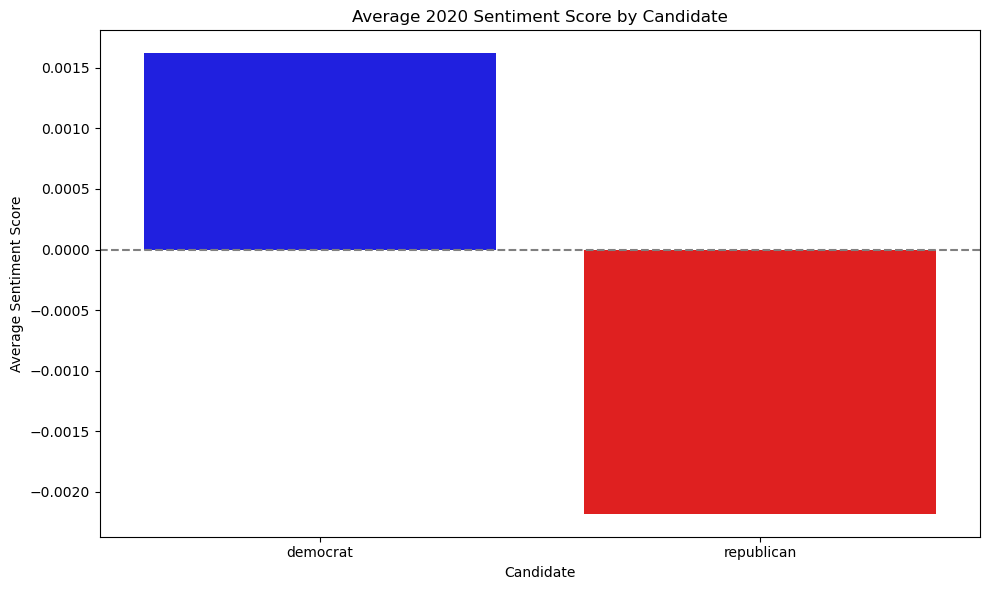

In [27]:
# Filter out the 'unknown' candidate from candidate_sentiments_summary
filtered_sentiments = candidate_sentiments_summary[candidate_sentiments_summary['candidate'] != 'unknown']

# Define a color palette for the diverging bar plot
color_palette = {
    'democrat': 'blue',
    'republican': 'red'
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Create the diverging bar plot
sns.barplot(
    data=filtered_sentiments,  # Use the filtered data
    x='candidate',
    y='average_sentiment',
    palette=color_palette,  # Use custom colors for Democrat and Republican
    dodge=True
)

# Add labels and title
plt.xlabel('Candidate')
plt.ylabel('Average Sentiment Score')
plt.title('Average 2020 Sentiment Score by Candidate')

# Add a horizontal line at y=0 for better visual comparison
plt.axhline(0, color='gray', linestyle='--')

# Show the plot
plt.xticks(rotation=0)  # Rotate x labels for better readability
plt.tight_layout()
plt.savefig('../Visualizations/avg_sent_by_cand_2020.png')
plt.show()

In [28]:
# Aggregate average sentiment scores by candidate
average_sentiments = sm20_with_candidates.groupby('candidate').agg({
    'Positive': 'mean',
    'Negative': 'mean',
    'Neutral': 'mean'
}).reset_index()

# Verify the result
print(average_sentiments)

    candidate  Positive  Negative   Neutral
0    democrat  0.079930  0.066022  0.854043
1  republican  0.088572  0.094166  0.817244
2     unknown  0.000000  0.000000  1.000000


In [29]:
# Drop rows where the candidate is 'unknown'
average_sentiments = average_sentiments[average_sentiments['candidate'] != 'unknown']

# Verify the result
print(average_sentiments)

    candidate  Positive  Negative   Neutral
0    democrat  0.079930  0.066022  0.854043
1  republican  0.088572  0.094166  0.817244


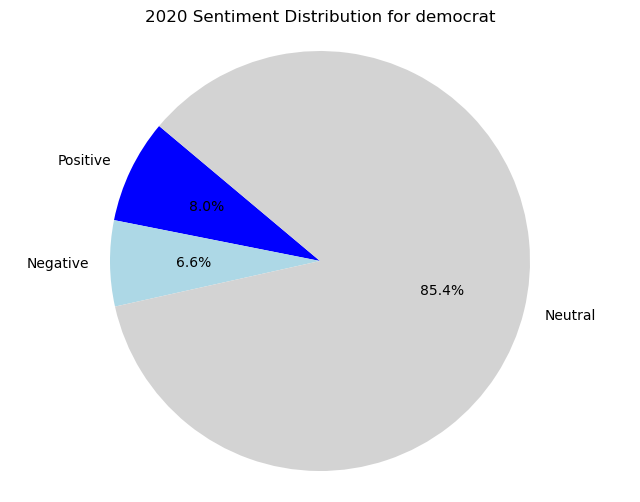

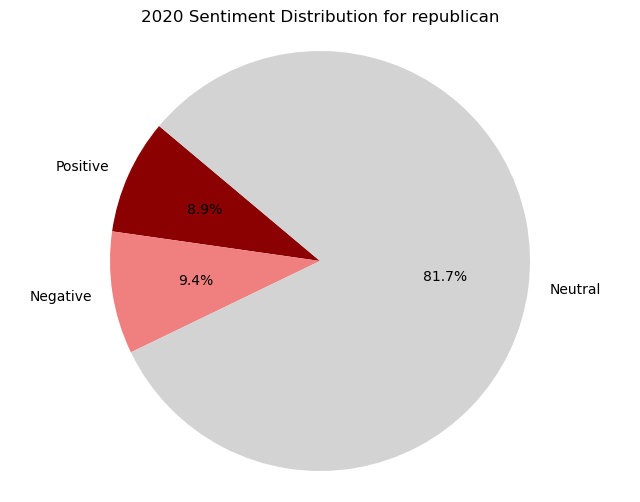

In [30]:
# Define function to plot pie chart

# Define color palette for sentiments
color_palettes = {
    'democrat': {
        'Positive': 'blue',  
        'Negative': 'lightblue',   
        'Neutral': 'lightgrey'
    },
    'republican': {
        'Positive': 'darkred',     
        'Negative': 'lightcoral', 
        'Neutral': 'lightgrey'
    }
}

def plot_pie_chart(data, candidate):
    # Extract sentiment values
    sizes = [data['Positive'], data['Negative'], data['Neutral']]
    labels = ['Positive', 'Negative', 'Neutral']
    colors = color_palettes.get(candidate, {
        'Positive': 'grey',
        'Negative': 'grey',
        'Neutral': 'grey'
    }).values()

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'2020 Sentiment Distribution for {candidate}')
    plt.axis('equal')  
    plt.savefig('../Visualizations/pos_neg_neut_by_party_2020.png')
    plt.show()

# Filter the DataFrame for each candidate
for candidate in average_sentiments['candidate']:
    candidate_data = average_sentiments[average_sentiments['candidate'] == candidate].iloc[0]
    plot_pie_chart(candidate_data, candidate)